# MLP Project 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


**1. Imports & Setup**

In this step, we import all necessary libraries such as pandas, numpy for data handling,
matplotlib and seaborn for visualization, and scikit-learn/xgboost for modeling.

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

**2. Load Data**

We load the training, testing, and sample submission files using pandas.
Initial inspection includes checking shapes and missing values to understand the dataset structure.
Read train, test, and sample submission files. Print dataset shapes and check for missing values.

In [3]:
train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")

In [4]:
sample_submission.head()

,ID,purchaseValue
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [5]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


In [6]:
train_df.shape

(116023, 52)

In [7]:
train_df.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [9]:
train_df.isnull().sum()

trafficSource.isTrueDirect                       73133
purchaseValue                                        0
browser                                              0
device.screenResolution                              0
trafficSource.adContent                         113060
trafficSource.keyword                            71861
screenSize                                           0
geoCluster                                           0
trafficSource.adwordsClickInfo.slot             111742
device.mobileDeviceBranding                          0
device.mobileInputSelector                           0
userId                                               0
trafficSource.campaign                               0
device.mobileDeviceMarketingName                     0
geoNetwork.networkDomain                             0
gclIdPresent                                         0
device.operatingSystemVersion                        0
sessionNumber                                        0
device.fla

# Graphs ( EDA )

In this step, we visualize the distribution of the target (`purchaseValue`) using histograms and boxplots.
We also examine categorical features using bar plots and relationships between features and the target using scatter plots.
Visualize target variable distribution
Check category distribution for key features
Generate correlation heatmap and plot numeric feature relationships

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


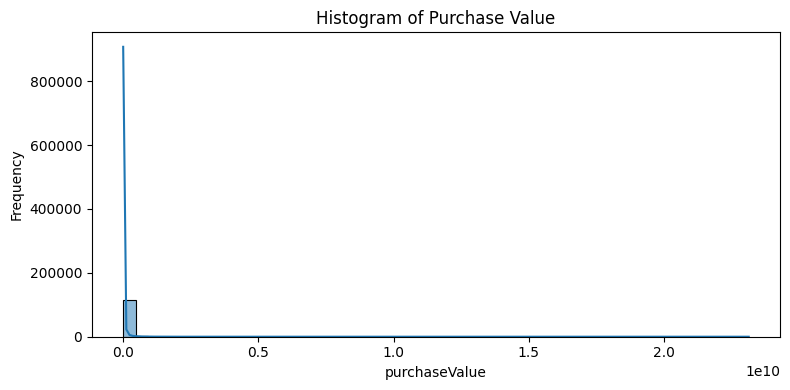

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['purchaseValue'], bins=50, kde=True)
plt.title("Histogram of Purchase Value")
plt.xlabel("purchaseValue")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

 1. Histogram of purchaseValue
Observation:

The distribution of purchaseValue is highly right-skewed, with many sessions having low or zero value. A few sessions have significantly higher purchase values, indicating the presence of outliers.

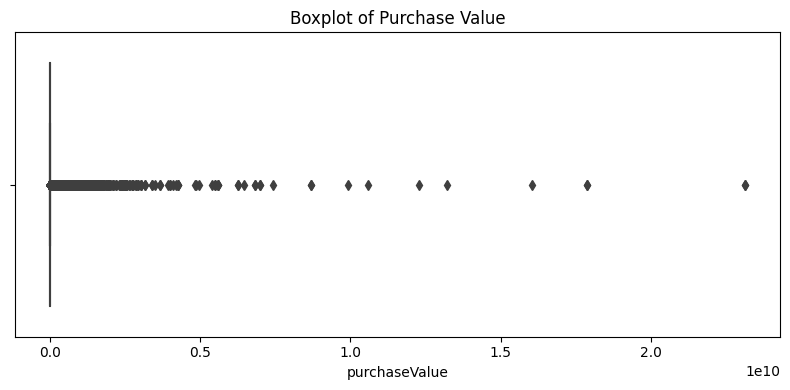

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['purchaseValue'])
plt.title("Boxplot of Purchase Value")
plt.xlabel("purchaseValue")
plt.tight_layout()
plt.show()

2. Boxplot of purchaseValue
Observation:

The boxplot confirms the presence of several outliers on the higher end. The majority of the purchase values are concentrated in the lower range, suggesting that most sessions result in low spending.

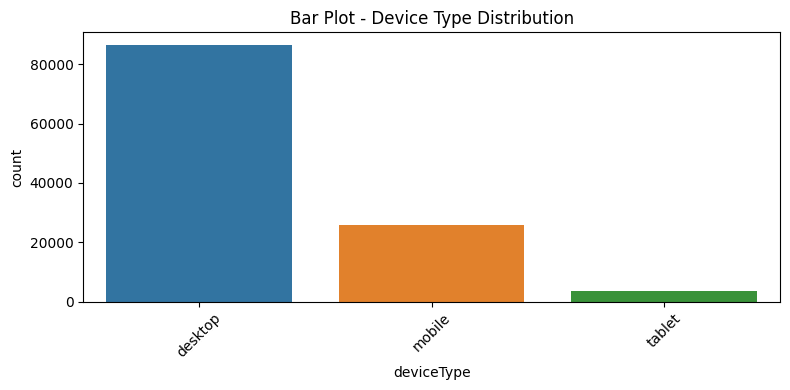

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(x='deviceType', data=train_df, order=train_df['deviceType'].value_counts().index[:10])
plt.title("Bar Plot - Device Type Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. Bar Plot of deviceType
Observation:

Most users accessed the platform using a desktop device, followed by mobile users. Other device types are used much less frequently, showing a clear device preference among users.

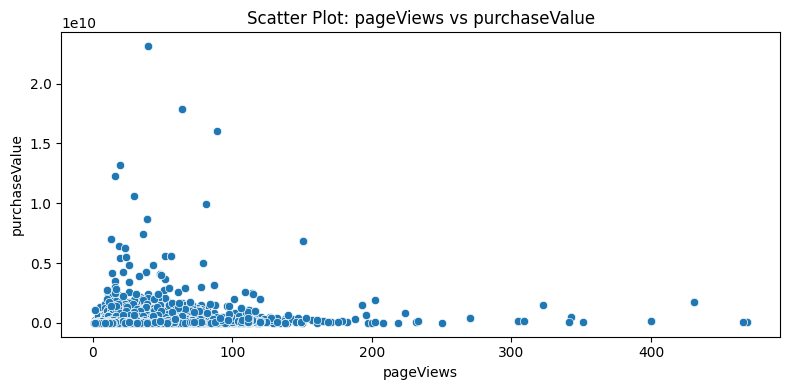

In [13]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=train_df, x='pageViews', y='purchaseValue')
plt.title("Scatter Plot: pageViews vs purchaseValue")
plt.xlabel("pageViews")
plt.ylabel("purchaseValue")
plt.tight_layout()
plt.show()

4. Scatter Plot: pageViews vs purchaseValue
Observation:

There is a weak positive relationship between pageViews and purchaseValue. While higher page views can lead to higher purchases, the trend is not consistent — indicating that page views alone are not a strong predictor of purchase behavior.

# Data cleaning and Pre Processing

**We clean the data by dropping single value columns**

Features with only one unique value do not contribute to the model and are dropped to reduce noise.
Remove features with the same value across all rows as they provide no variability.

In [14]:
single_val_cols = train_df.nunique()[train_df.nunique() == 1].index.tolist()
train_df.drop(columns=single_val_cols, inplace=True)
test_df.drop(columns=single_val_cols, errors='ignore', inplace=True)


**We set targer variables**

In this step, we define our target variable `purchaseValue`, which represents the purchase made in a user session.
We split the data into:
**`X`** (features): all columns **except** the target
**`y`** (target): the `purchaseValue` column

In [15]:
target = 'purchaseValue'
X = train_df.drop(columns=[target])
y = train_df[target]

we categorize the features into:
**Numerical columns**: Columns with data types `int64`, `float64`, or `bool`
**Categorical columns**: Columns with data type `object`

This separation helps in applying different preprocessing strategies to each type (e.g., scaling numerics, encoding categoricals) during pipeline setup.

In [16]:
numeric_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

**Feature Selection Strategy**

We classified categorical columns based on their number of unique values:
Columns with **≤10 unique values** were treated as **low-cardinality**, suitable for One-Hot Encoding.
Columns with **>10 unique values** were excluded from direct encoding due to high cardinality, which can lead to sparse and overfit models.

We combined:
`numeric_cols` + `ohe_cols`  
to build our final `selected_features` list.  
This selection ensures only meaningful, manageable features are passed into the pipeline.


In [17]:
ohe_cols = [col for col in categorical_cols if X[col].nunique() <= 10]
exclude_cols = [col for col in categorical_cols if X[col].nunique() > 10]

selected_features = numeric_cols + ohe_cols
X = X[selected_features]
test_X = test_df[selected_features]

**Preprocessing Pipeline**

We build a preprocessing pipeline using `ColumnTransformer` to apply appropriate transformations to different types of columns:

**Numeric columns** (`numeric_cols`):
Missing values are imputed using the **median** strategy.
  
**Categorical columns** (`ohe_cols`):
Missing values are imputed using the **most frequent** category.
Then, encoded using **OneHotEncoder** to convert categories into binary columns.

Both pipelines are wrapped into a single `ColumnTransformer` named `preprocessor`, which ensures the right preprocessing is applied to each column group during model training.


In [18]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, ohe_cols)
])


# Model Building

**We chose models and assign the no of estinators , random state and other parameters**

We compare multiple regression models:
LinearRegression: baseline model
Ridge: regularized linear model
RandomForest: tree-based ensemble model
XGBoost: advanced gradient boosting model

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1) }

Linear Regression - It assumes that there's a straight-line relationship between the features and the target ( y = mx + c )

Ridge is just like Linear Regression but adds a penalty to the loss function to avoid overfitting.

Random Forest is a combination model , it bags and builds many decision trees, each on a different random subset of data and features, and then averages their predictions . It reduces variance hence to avoid over fitting.

XGBoost is a boosting model, so it builds trees one after another, where each new tree tries to fix the errors of the previous ones. It’s smarter and more optimized than Random Forest

**We chose the best model**

In [20]:
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    results[name] = {
        "R2 Mean": np.mean(scores),
        "R2 Std": np.std(scores)
    }

results_df = pd.DataFrame(results).T.sort_values("R2 Mean", ascending=False)
print("\nModel Performance (R2 Score):\n")
print(results_df.round(4))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.24139e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.24689e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25998e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.24186e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin


Model Performance (R2 Score):

                   R2 Mean  R2 Std
Random Forest       0.4176  0.1546
XGBoost             0.2248  0.1245
Ridge Regression    0.1073  0.0196
Linear Regression   0.1073  0.0196


# Hyperparameter

A hyperparameter is like a pre defined setting that we choose before training the model.
It controls how the model learns like how complex (iterations) it can get, or how fast the model learns .

**We perform Hyperparameter to choose the best model**

we use RandomizedSearchCV to optimize the performance of our XGBoost model. Instead of manually setting parameters, we define a parameter grid and let the search algorithm find the best combination based on cross-validated R² score.

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4)
}

search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X, y)
print("\nBest R2 Score from Tuning:", round(search.best_score_, 4))
print("Best Parameters:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best R2 Score from Tuning: 0.4598
Best Parameters: {'regressor__colsample_bytree': 0.6571467271687763, 'regressor__learning_rate': 0.14017769458977059, 'regressor__max_depth': 7, 'regressor__n_estimators': 357, 'regressor__subsample': 0.8887995089067299}


**We select the final Model**

he best model is retrained on the full dataset and used to predict on the test set.
Predictions are inverse-transformed from log scale using `np.expm1()` and written to a CSV file in required format.

In [22]:
final_model = search.best_estimator_
final_model.fit(X, y)
preds = final_model.predict(test_X)
preds

array([25706618.  ,  -538140.5 , -2430173.5 , ..., 21712600.  ,
        -372325.75,  1120466.9 ], dtype=float32)

# Final Submission file

In [23]:
final_model = search.best_estimator_
final_model.fit(X, y)
preds = final_model.predict(test_X)

submission = pd.DataFrame({
    'id': sample_submission['ID'],
    'purchaseValue': preds
})
submission.to_csv("submission.csv", index=False)
print("\nsubmission.csv created successfully.")


submission.csv created successfully.
